# Three-dimensional STSSCAN 

In [3]:
%matplotlib inline
%load_ext pycodestyle_magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing
import copy

from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from metrics import *

In [4]:
_x_test = np.array([[1,1],[-1,1]])
_y_test = np.array([[1,1],[-1,1]])

test = list()
test.append(_x_test)
test.append(_y_test)
np.array(test)

three_dimensional_msr(np.array(test))

1.0

In [5]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterABC_high.csv',header=None)
# scaler = MinMaxScaler()
#scaler.fit(data)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


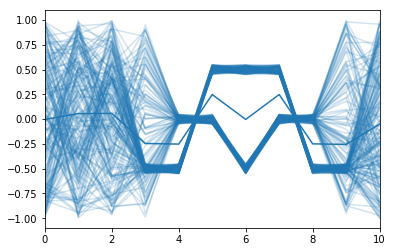

In [6]:
sns.tsplot(np.array(data)[100:], err_style='unit_traces')

In [7]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.82956,-0.54831,0.009606,0.54954,0.64886,0.090355,0.65218,0.12476,0.91613,0.90735,-0.370470
1,0.15286,-0.53179,0.012793,0.46622,0.71576,-0.874990,-0.23763,0.37047,-0.83904,-0.98532,0.175840
2,-0.31950,-0.46583,-0.012242,0.47949,-0.43445,0.070250,-0.22041,-0.15626,-0.17891,0.62023,-0.648240
3,0.18276,-0.49303,-0.032042,0.46603,-0.11152,0.295060,-0.40524,-0.60485,-0.13659,0.21066,0.012703
4,0.96534,-0.49391,0.024100,0.45677,-0.13357,0.062244,-0.92875,0.56100,-0.13701,-0.29148,-0.643040


In [8]:
trajectories = list()

In [9]:
for col in data.columns:
    trajectories.append(np.dstack((data[col],data[col]))[0])

In [10]:
trajectories = np.transpose(trajectories,(1,0,2))


In [11]:
trajectories.transpose(1,0,2).shape

(11, 300, 2)

In [12]:
trajectories.shape

(300, 11, 2)

In [13]:
class Bicluster(object):
    
    def __init__(
        self, 
        data, 
        rho=None,
        gamma=None, 
        bisected=False,
        H_max=None, 
        best_bisection=None
    ):
        
        """
        Bicluters structure
        
        
        :param rho: <np.array[int]> the map of the indices of rows of the bicluster i.e [2,4,7,8]
        :param gamma: <np.array[int]> the map of gammas, same structure f rho
        :param bisected: <boolean> indicates if the bicluster has been bisected recentky
        :param h_max: <float> best h from the last bisection
        :paran best_bisection: <np.array[int]> mapping array from the best bisection
        
        *Note: Noise will be represented as -1
        
        """
        
        self.gamma = gamma
        self.rho = rho
        self.bisected = bisected
        self.h_max = H_max
        self.bisected_direction = best_bisection.flg_direction if best_bisection is not None else None
        self.best_bisection = best_bisection
        self.data = data[np.ix_(self.rho, self.gamma)]

    def set_bisected(self):
        
        self.bisected = not self.bisected
    
    def __str__(self):
        
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))
                
    def row_length(self):
        
        return len(self.rho>=0)
    
    def col_length(self):
        
        return len(self.gamma>=0)
    
    def set_fields(self, best_bisection, h_max, bisected_direction):
        
        """
        Method
        
        :param best_bisection: <np.array[int]> Mapping array from the best bisection 
        :param h_max: <float> Best H from the last bisection
        :bisected_direction: <String> Direction from the last bisection ('cols' or 'rows')
        """
        
        self.best_bisection = best_bisection
        self.h_max = h_max
        self.bisected_direction = bisected_direction
        final_map = best_bisection == 0 # filtering noise then zeros

        if(bisected_direction == 'cols'):
            
            self.gamma = self.gamma[final_map]
            print(self.gamma)
            
        else:
            
            self.rho = self.rho[final_map]
            
    def compute_H(self, data):
        
        """
        Method:
        Computes the coherence H of the data
        """
        
        self.data = data[np.ix_(self.rho, self.gamma)]
        self.H = three_dimensional_msr(self.data)
        
        return self.H

In [124]:
def split_cols(data, min_coherence):
    
    """
    Function:
    Spits the bicluster according to the best split in of columns
    
    :param data: <np.array[np.array]> data of the bicluster to split
    :param bicluster: <Bicluster> data 
    :param min_coherence: <float> minimal coherence of a bicluster
    """
    
    t_data = data.transpose(1,0,2)
    aux_I, aux_J = t_data.shape[0:2]
    aux_indices = np.zeros(aux_I)
    middle = 0
    max_h = 0
    temp_max = 0
    flg_noise_cleaning = False
    temp_h_right = 0
    temp_h_left = 0
    
    for i in range(1, aux_I-1):

        temp_h_right = three_dimensional_msr(t_data[i:len(t_data)])
        temp_h_left = three_dimensional_msr(t_data[0:i+1])
        temp_max = max(temp_h_right, temp_h_left)
        
        if (temp_max >= max_h):
            
            max_h = temp_max
            middle = i
            
    indices = np.ones(aux_I)
    zeros = np.zeros(middle)
    
    if len(indices) == 1 or temp_h_left <= min_coherence:
        indices = np.array(-1*np.ones(len(indices)))
        flg_noise_cleaning = True
        
    if len(zeros) == 1 or temp_h_right <= min_coherence:
        zeros = np.array(-1*np.ones(len(zeros)))
        flg_noise_cleaning = True
        
    indices[0:middle] = zeros
    indices = np.array(indices)  
    unique_indices = np.unique(indices)
    
    return (indices, max_h, flg_noise_cleaning)

In [125]:
def transform_dm(dm):
    dm[dm < 0] = 0
    dm = 1-dm**4
    np.fill_diagonal(dm, 0)
    
    return dm

In [162]:
def split_rows(data, min_cluster_size):
    
    """
    Apply DBSCAN over the bicluster to filter noise
    
    :param bicluster: <Bicluster> data
    :param min_cluster_size
    """
    
    n_cols = data.shape[1]
    dm = np.asarray([[((three_dimensional_coherence(p1, p2)) \
                       if (three_dimensional_coherence(p1, p2)) \
                       != 1 \
                       else 0.0) 
                      for p2 in data]\
                     for p1 in data])
    dm = transform_dm(dm)
    gmm = GaussianMixture(n_components=3)
    gmm.fit(np.array([(dm).flatten()]).T)
    eps = gmm.means_[np.where(gmm.weights_\
                              ==(min(gmm.weights_)))].flatten()
    dev = gmm.covariances_.flatten()[np.where(gmm.weights_\
                                              ==(min(gmm.weights_)))]
    lower_bound = 0 #eps - 8*dev
    rows = np.array([])
    
    
    while (eps) > lower_bound:
        
        db = DBSCAN(eps = eps ,metric='precomputed', 
                    min_samples=min_cluster_size,
               ).fit(dm)
        
        # print(db.labels_)
        rows = db.labels_
        
        if(len(np.unique(db.labels_))<3):
            
            eps -= dev/4
            if eps <= 0:
                
                eps = 1.0e-15
                break
        else:
            
            break

    map_array = rows
    tmp_bicluster_label = 0
    max_h = 0
    
    for i in np.unique(rows):
        
        if i == -1:
            
            pass
        
        else:
            
            temp_h = three_dimensional_msr(data[np.where(rows == i)])
            
            if temp_h >= max_h:
                max_h = temp_h
                tmp_bicluster_label = i

    final_array = np.array([1 if value == tmp_bicluster_label else (0 if value != -1 else -1) 
                            for value in db.labels_])
    map_array = final_array
    flg_noise_cleaning = False
    unique_array = np.unique(final_array)
    
    if (len(unique_array) == 2 and unique_array[0] == -1):
        
        flg_noise_cleaning = True
    
    new_map = map_array
        
    if ((np.unique(map_array)[0] == -1) and len(np.unique(map_array)) == 1):
        
        print("all negatives", len(map_array))
        new_map = np.ones(int(len(map_array)))
        zeros = np.zeros(int(len(map_array)/2))
        new_map[0:int(len(map_array)/2)] = zeros
        print(new_map)
        flg_noise_cleaning = False
        map_array = new_map.copy()
        max_h = 0
    
    return (map_array, max_h, flg_noise_cleaning)

In [163]:
def compute_bicluster_coherence(bicluster, 
                                min_cluster_row_size,
                                min_coherence):
    
    """
    Splits bicluster and chooses wether its better to split rows or columns
    
    :param bicluster: <Bicluster> Bicluster to split
    :param min_coherence: <float> minimal coherence of a bicluster
    """
    
    print("Compute Coherence")
    
    flg_noise_cleaning_rows = False
    flg_noise_cleaning_cols = False
    
    if (bicluster.bisected):
    
        return (bicluster.best_bisection, bicluster.h_max, bicluster.bisected_direction)
    else:
        
        map_array_cols, h_cols, flg_noise_cleaning_cols = split_cols(bicluster.data, min_coherence=min_coherence)
        map_array_rows, h_rows, flg_noise_cleaning_rows = split_rows(bicluster.data, min_cluster_row_size)
        print("\nmap array rows len ", len(map_array_rows))
        # print("h cols " + str(h_cols) + " h rows " + str(h_rows))
        
        if (h_cols > h_rows):
            
            if flg_noise_cleaning_cols:
                
                return (map_array_cols, h_cols, "clean cols")
            else:
 
                return (map_array_cols, h_cols, "cols")
        else:
            
            if flg_noise_cleaning_rows:
                
                return (map_array_rows, h_rows, "clean rows")
            
            return (map_array_rows, h_rows, "rows")

In [164]:


class STSSCAN(object):

    def __init__(self, data, n_clusters=2, min_coherence = 0.9):
        """
        STSSCAN
        
        Applies biclustering over data
        
        :param data: <np.array> The data to apply biclusters
        :param n_clusters: <int> The number of biclusters to find
        
        """

        assert data is not None, 'Empty data'
        self._data = data
        (self._I, self._J) = self._data.shape[0:2]
        self._n_clusters = n_clusters
        self._biclusters = list()
        self._objective_function = 0
        self._min_coherence = min_coherence

    @property
    def n_clusters(self):
        return self._n_clusters

    @property
    def data(self):
        return self._data

    @property
    def biclusters(self):
        return self._biclusters

    def fit(self):
        """
        Fits the data on the algorithm. Iters over the 
        number of biclusters until find the requested number
        """

        print ('Fitting data ')
        n_iterations = 0
        n_clusters = self._n_clusters
        initial_bicluster = Bicluster(self._data, np.arange(self._I),
                np.arange(self._J))
        self._biclusters.append(initial_bicluster)
        
        while len(self._biclusters) != self.n_clusters:
            
            print('\nN iteration ' + str(n_iterations))
            
            self._split_biclusters() 
            n_iterations += 1
        # self._prune()

    def _split_biclusters(self):
        """
        Splits bicluters in order to find the next biclusters that optimizes
        the sum of coherences among biclusters
        """

        # import ipdb; ipdb.set_trace()

        print()
        print('Splitting biclusters ')

        h_max = 0
        tmp_bicluster_delta = 0
        tmp_bisection = None
        tmp_split = 'cols'
        tmp_bisection_direction = None
        position = 0
        best_position = 0
        best_bisection_array = np.array([])
        best_bisection_direction = None

        while position != len(self._biclusters):

            bicluster = self._biclusters[position]
            
            print()
            
            print('Position ' + str(position))
            
            print('\nRow length ' + str(bicluster.row_length()) + ' Col length ' + str(bicluster.col_length()) + '\n')
            
            min_cluster_row_size = math.floor(np.log(self._I) * 5)

            if bicluster.row_length() >= min_cluster_row_size and bicluster.col_length() > 2:

                (tmp_bisection, tmp_bicluster_delta, tmp_split) = compute_bicluster_coherence(bicluster, min_cluster_row_size, self._min_coherence)

                if tmp_split == 'clean cols':

                    index_map = tmp_bisection.copy() >= 0
                    rho = self._biclusters[position].rho.copy()
                    new_gamma = self._biclusters[position].gamma.copy()[index_map]
                    self._biclusters[position] = Bicluster(self._data,
                            rho, new_gamma)
                    best_bisection_direction = 'clean'
                    
                    print('\nCleaned cols at ' + str(position))
                    
                elif tmp_split == 'clean rows':

                    index_map = tmp_bisection.copy() >= 0
                    rho = self._biclusters[position].rho.copy()[index_map]
                    new_gamma = self._biclusters[position].gamma.copy()
                    self._biclusters[position] = Bicluster(self._data,
                            rho, new_gamma)
                    best_bisection_direction = 'clean'
                    print('\nCleaned rows at ' + str(position))
                else:

                    if tmp_bicluster_delta >= h_max:
                        
                        h_max = tmp_bicluster_delta
                        best_position = position
                        best_bisection_array = tmp_bisection.copy()
                        best_bisection_direction = ('cols'
                                 if tmp_split == 'cols' else 'rows')
            position += 1

        if best_bisection_direction != 'clean':
            
            print('\nBisected bicluster at ' + str(best_position))
            best_bisection = best_bisection_array
            self._add_bicluster(best_position, best_bisection, h_max,
                                best_bisection_direction)

    def _add_bicluster(
        self,
        best_position,
        best_bisection,
        h_max,
        bisection_direction,
        ):
        
        """
        Adds the found bicluster into the list of labels
        
        :param best_position: <int> position of the best bicluster
        :param best_bisection: <np.array[int]> map_array of the best bisection
        :param max_delta: h_max 
        """

        # Create the new bicluster

        best_rho = self._biclusters[best_position].rho
        best_gamma = self._biclusters[best_position].gamma
        index_map = best_bisection >= 1
        aux_index_map = best_bisection == 0
        
        if bisection_direction == 'cols':
            
            new_rho = best_rho.copy()
            new_gamma = best_gamma[index_map].copy()
            aux_rho = best_rho.copy()
            aux_gamma = best_gamma[aux_index_map].copy()
            
            # print('\nAdded bicluster cols: ' + str(new_gamma))
            
        else:
            
            new_gamma = best_gamma.copy()
            new_rho = best_rho[index_map].copy()
            aux_rho = best_rho[aux_index_map].copy()
            aux_gamma = best_gamma.copy()
            
            # print('\nAdded bicluster rows: ' + str(new_rho))
            
        new_bicluster = Bicluster(self._data, new_rho, new_gamma)

        self._biclusters.append(new_bicluster)

        # Modify the bicluster that is going to be bisected

        self._biclusters[best_position] = Bicluster(self._data, aux_rho, aux_gamma)

    def _prune(self):

        for position in range(0, len(self._biclusters)):

            print(position)

            rho = self._biclusters[position].rho
            gamma = self._biclusters[position].gamma

            if len(gamma) > 0:

                stds = np.std(self._data[np.ix_(rho, gamma)], axis=0)
                std = np.mean(stds)
                lst_map = list()

                print('std ' + str(std))

                for index in [0, len(stds) - 1]:
                    
                    if stds[index] <= std * 2:
                        
                        lst_map.append(1)
                    else:
                        
                        lst_map.append(0)

                print(lst_map)
    
    def merge(self):
        
        index = 0
        
        for index in range(0,len(self._biclusters)):
            
            sub_index = 0
            
            for sub_index in range(index+1,len(self._biclusters)):
                
                if (max(self._biclusters[index].gamma) == min(self._biclusters[sub_index].gamma) and 
                    self._biclusters[index].rho == self._biclusters[sub_index].rho
                   ):
                    
                    print("Merge " + str(index) + " with " + str(sub_index)) 


In [158]:
stsscan = STSSCAN(np.array(trajectories)[50:], 5, 0.7)

In [159]:
Bicluster(np.array(trajectories)[50:],[0,1,2],[0,1,2]).data

array([[[-0.18376 , -0.18376 ],
        [-0.49544 , -0.49544 ],
        [-0.046682, -0.046682]],

       [[-0.32953 , -0.32953 ],
        [-0.47601 , -0.47601 ],
        [-0.040743, -0.040743]],

       [[-0.46141 , -0.46141 ],
        [-0.52825 , -0.52825 ],
        [ 0.016429,  0.016429]]])

In [172]:
data = pd.read_csv("../data/Raw/Erk.csv", sep=";")
neg_data = data[data["Pvalue"]>0.5]
pos_data = data[(data["Pvalue"]<=0.01)]

In [173]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pos_data, train_size=0.9)
neg_test = neg_data.sample(len(train) + len(test))
train_cause = train[train.columns[5:14]]
train_effect = train[train.columns[14:]]

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [174]:
train_trajectories = list()

for i in range(len(train_cause.columns)):
    
    train_trajectories.append(np.dstack((train_cause[train_cause.columns[i]], 
                                         train_effect[train_effect.columns[i]]))[0]
                             )
train_trajectories = np.transpose(np.array(train_trajectories),[1,0,2])
train_trajectories = np.array(train_trajectories)

In [176]:
stsscan2 = STSSCAN(train_trajectories, 2, 0.7)

In [177]:
stsscan2.fit()

Fitting data 

N iteration 0

Splitting biclusters 

Position 0

Row length 237 Col length 9

Compute Coherence
all negatives 237
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [178]:
stsscan2.biclusters[0].gamma

array([0, 1, 2, 3, 4])

In [179]:
stsscan2.biclusters[0].rho

array([  0,  11,  26,  36,  38,  41,  42,  43,  44,  46,  48,  53,  54,
        56,  62,  64,  67,  68,  77,  80,  87,  94,  97, 103, 108, 109,
       114, 123, 127, 131, 135, 137, 143, 144, 154, 155, 156, 162, 164,
       170, 177, 180, 186, 190, 192, 198, 205, 207, 208, 209, 222, 223,
       225, 226, 233])

In [170]:
stsscan3 = STSSCAN(train_trajectories, 3, 0.7)
stsscan3.fit()

Fitting data 

N iteration 0

Splitting biclusters 

Position 0

Row length 237 Col length 9

Compute Coherence
all negatives 237
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [171]:
print("rho ", stsscan3.biclusters[0].rho, " gamma ", stsscan3.biclusters[0].gamma)
print()
print("rho ", stsscan3.biclusters[1].rho, " gamma ", stsscan3.biclusters[1].gamma)
print()
print("rho ", stsscan3.biclusters[2].rho, " gamma ", stsscan3.biclusters[2].gamma)

rho  [  0   3   5  14  16  18  19  22  34  36  39  41  42  43  46  48  49  50
  54  56  59  63  64  65  71  72  77  81  85  86  89  91  92  99 104 105
 107 109 111 112 113 114 121 123 124 125 130 131 132 138 139 140 141 142
 143 144 147 148 149 151 152 154 156 157 163 165 166 168 170 174 177 183
 186 188 189 190 191 192 194 199 200 201 206 210 212 214 215 218 221 223
 226 228]  gamma  [0 1 2 3 4 5 6]

rho  [  4  24  28  32  35  60  67  68  69  70  78  80  82  95  96  97 103 116
 117 120 128 150 160 197 207 217 224]  gamma  [0 1 2 3 4]

rho  [  4  24  28  32  35  60  67  68  69  70  78  80  82  95  96  97 103 116
 117 120 128 150 160 197 207 217 224]  gamma  [5 6]


In [73]:
def print_biclusters(stsscan):
    
    for i in range(len(stsscan.biclusters)):
        print()
        print("bicluster ", i)
        print("rho:\n", stsscan.biclusters[i].rho, "\n\ngamma:\n", stsscan.biclusters[i].gamma)

In [55]:
print_biclusters(stsscan3)


bicluster  0
rho:
 [  0   2   5   6   8  12  13  14  17  19  21  23  27  28  29  30  31  32
  33  34  35  37  39  40  42  43  46  49  53  58  60  61  65  69  71  72
  75  76  77  80  85  86  88  90  91  93  94  95  96  97  98  99 100 102
 103 106 107 108 110 111 112 118 121 124 125 126 128 133 135 136 139 144
 145 148 151 153 155 156 158 159 160 165 167 169 171 172 173 174 176 177
 179 183 185 186 188 189 190 197 203 204 205 206 207 209 210 216 217 218
 221 226 227 228 229 235] 

gamma:
 [0 1 2 3 4]

bicluster  1
rho:
 [  4  10  22  25  36  51  52  73  82 101 117 120 138 149 150 162 164 199
 212 215 219 224 234] 

gamma:
 [0 1 2 3 4 5 6]

bicluster  2
rho:
 [  0   2   5   6   8  12  13  14  17  19  21  23  27  28  29  30  31  32
  33  34  35  37  39  40  42  43  46  49  53  58  60  61  65  69  71  72
  75  76  77  80  85  86  88  90  91  93  94  95  96  97  98  99 100 102
 103 106 107 108 110 111 112 118 121 124 125 126 128 133 135 136 139 144
 145 148 151 153 155 156 158 159 160 165 

In [57]:
stsscan4 = STSSCAN(train_trajectories, 4, 0.7)
stsscan4.fit()

Fitting data 

N iteration 0

Splitting biclusters 

Position 0

Row length 237 Col length 9

Compute Coherence

Cleaned cols at 0

N iteration 1

Splitting biclusters 

Position 0

Row length 237 Col length 7

Compute Coherence

Bisected bicluster at 0

N iteration 2

Splitting biclusters 

Position 0

Row length 113 Col length 7

Compute Coherence

Position 1

Row length 22 Col length 7


Bisected bicluster at 0

N iteration 3

Splitting biclusters 

Position 0

Row length 113 Col length 5

Compute Coherence

Position 1

Row length 22 Col length 7


Position 2

Row length 113 Col length 2


Bisected bicluster at 0


In [58]:
print_biclusters(stsscan4)


bicluster  0
rho:
 [  0   2   5   6   8  12  13  14  17  19  21  23  27  28  29  30  31  32
  33  34  35  37  39  40  42  43  46  49  53  58  60  61  65  69  71  72
  75  76  77  80  85  86  88  90  91  93  94  95  96  97  98  99 100 102
 103 106 107 108 110 111 112 118 121 124 125 126 128 133 135 136 139 144
 145 148 151 153 155 156 159 160 165 167 169 171 172 173 174 176 177 179
 183 185 186 188 189 190 197 203 204 205 206 207 209 210 216 217 218 221
 226 227 228 229 235] 

gamma:
 [0 1 2]

bicluster  1
rho:
 [  4  10  22  25  36  51  52  73  82 101 117 120 138 149 150 162 164 212
 215 219 224 234] 

gamma:
 [0 1 2 3 4 5 6]

bicluster  2
rho:
 [  0   2   5   6   8  12  13  14  17  19  21  23  27  28  29  30  31  32
  33  34  35  37  39  40  42  43  46  49  53  58  60  61  65  69  71  72
  75  76  77  80  85  86  88  90  91  93  94  95  96  97  98  99 100 102
 103 106 107 108 110 111 112 118 121 124 125 126 128 133 135 136 139 144
 145 148 151 153 155 156 159 160 165 167 169 171 172 

In [92]:
stsscan5 = STSSCAN(train_trajectories, 5, 0.7)
stsscan5.fit()

Fitting data 

N iteration 0

Splitting biclusters 

Position 0

Row length 237 Col length 9

Compute Coherence
all negatives 237

Cleaned cols at 0

N iteration 1

Splitting biclusters 

Position 0

Row length 237 Col length 7

Compute Coherence

Bisected bicluster at 0

N iteration 2

Splitting biclusters 

Position 0

Row length 92 Col length 7

Compute Coherence
all negatives 92

Position 1

Row length 27 Col length 7

Compute Coherence
all negatives 27

Bisected bicluster at 1

N iteration 3

Splitting biclusters 

Position 0

Row length 92 Col length 7

Compute Coherence
all negatives 92

Position 1

Row length 27 Col length 5

Compute Coherence
all negatives 27

Position 2

Row length 27 Col length 2


Bisected bicluster at 1

N iteration 4

Splitting biclusters 

Position 0

Row length 92 Col length 7

Compute Coherence
all negatives 92

Position 1

Row length 27 Col length 2


Position 2

Row length 27 Col length 2


Position 3

Row length 27 Col length 3


Bisected bicluster 

In [93]:
print_biclusters(stsscan5)


bicluster  0
rho:
 [  0   3   5  14  16  18  19  22  34  36  39  41  42  43  46  48  49  50
  54  56  59  63  64  65  71  72  77  81  85  86  89  91  92  99 104 105
 107 109 111 112 113 114 121 123 124 125 130 131 132 138 139 140 141 142
 143 144 147 148 149 151 152 154 156 157 163 165 166 168 170 174 177 183
 186 188 189 190 191 192 194 199 200 201 206 210 212 214 215 218 221 223
 226 228] 

gamma:
 [0 1 2 3 4]

bicluster  1
rho:
 [  4  24  28  32  35  60  67  68  69  70  78  80  82  95  96  97 103 116
 117 120 128 150 160 197 207 217 224] 

gamma:
 [0 1]

bicluster  2
rho:
 [  4  24  28  32  35  60  67  68  69  70  78  80  82  95  96  97 103 116
 117 120 128 150 160 197 207 217 224] 

gamma:
 [5 6]

bicluster  3
rho:
 [  4  24  28  32  35  60  67  68  69  70  78  80  82  95  96  97 103 116
 117 120 128 150 160 197 207 217 224] 

gamma:
 [2 3 4]

bicluster  4
rho:
 [  0   3   5  14  16  18  19  22  34  36  39  41  42  43  46  48  49  50
  54  56  59  63  64  65  71  72  77  81  85  8

In [167]:
stsscan6 = STSSCAN(train_trajectories, 5, 0.7)
stsscan6.fit()

Fitting data 

N iteration 0

Splitting biclusters 

Position 0

Row length 237 Col length 9

Compute Coherence
all negatives 237
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [180]:
stsscan6.data

array([[[  1.57046122e+00,   1.41462194e+00],
        [ -2.59945662e-01,   1.34654092e+00],
        [  4.61186883e-01,   7.30797042e-01],
        ..., 
        [  7.09208450e-01,  -1.43889651e+00],
        [  8.49053723e-01,  -1.59754654e+00],
        [  5.60649686e-01,  -1.59674320e+00]],

       [[ -1.31957365e-01,   7.11492229e-01],
        [ -6.97083940e-02,  -8.44579988e-01],
        [  4.36723813e-01,   5.62983569e-01],
        ..., 
        [ -9.95972794e-01,  -1.30421140e+00],
        [ -1.98591966e-01,   1.44170462e+00],
        [ -8.64258080e-02,   6.97184252e-01]],

       [[ -1.31957365e-01,  -6.34650960e-02],
        [ -6.97083940e-02,  -2.46107338e-01],
        [  4.36723813e-01,  -4.01947577e-01],
        ..., 
        [ -9.95972794e-01,   7.65123244e-01],
        [ -1.98591966e-01,   4.42717212e-01],
        [ -8.64258080e-02,   6.30630377e-01]],

       ..., 
       [[  1.57046122e+00,   1.51536274e+00],
        [ -2.59945662e-01,   1.71204693e+00],
        [  4.611868

In [132]:
stsscan6.biclusters[0].rho


array([], dtype=int64)